In [1]:
%load_ext autoreload
%autoreload 2

from dsapol import parsec
from dsapol import polbeamform
from dsapol import polcal
#from dsapol import widget
import numpy as np
from matplotlib import pyplot as plt
from dsapol import dsapol
from scipy.signal import correlate
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.signal import fftconvolve
from scipy.ndimage import convolve1d
from scipy.signal import peak_widths
from scipy.stats import chi
from scipy.stats import norm
import copy
import glob
import csv


from numpy.ma import masked_array as ma
from scipy.stats import kstest
from scipy.optimize import curve_fit


from scipy.signal import find_peaks
from scipy.signal import peak_widths
import copy
import numpy as np

from sigpyproc import FilReader
from sigpyproc.Filterbank import FilterbankBlock
from sigpyproc.Header import Header
from matplotlib import pyplot as plt
import pylab
import pickle
import json
from scipy.interpolate import interp1d
from scipy.stats import chi2
from scipy.stats import chi
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.ndimage import convolve1d
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from RMtools_1D.do_RMclean_1D import run_rmclean
from RMtools_1D.do_QUfit_1D_mnest import run_qufit
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u

import pandas as pd
import mercury as mr

In [2]:

app = mr.App(title="(V2) Polarization Analysis Dashboard", description="With this dashboard, you can conduct RM synthesis, get polarization fractions, and conduct de-dispersion tuning.")

mercury.App

In [3]:
# Toggle Sliders Button: switches between panels of widgets for different slides
toggle_menu = mr.Select(label='Toggle Widget Panels',
                       value='(0) Load Data',
                       choices=['(0) Load Data',
                               '(1) Dedispersion Tuning',
                               '(2) Calibration -- Beamform Cal Voltages',
                               '(2) Calibration -- Make Cal Filterbanks',
                               '(2) Calibration -- Choose Cal Observations',
                               r'(2) Calibration -- Make Cal Solutions ($|g_{yy}|$)',
                               r'(2) Calibration -- Make Cal Solutions ($|g_{xx}|/|g_{yy}|$)',
                               r'(2) Calibration -- Make Cal Solutions ($\angle g_{xx} - \angle g_{yy}$)',
                               r'(2) Calibration -- Calibrate',
                               '(3) Filter Weights'])

mercury.Select

# (0) Load Data

In [4]:
# widgets
hidden = toggle_menu.value != '(0) Load Data'
#frbfiles = parsec.get_frbfiles()
frbfiles_menu = mr.Select(label="FRB (candname_nickname):", 
                            value=parsec.wdict['frbfiles_menu'],
                            choices=parsec.frbfiles,
                            hidden=hidden)#frbfiles[0], choices=frbfiles,hidden=hidden)
base_n_t_slider = mr.Slider( #time downsampling factor
    value=parsec.wdict['base_n_t_slider'],
    min=1, 
    max=128, 
    step=1, 
    label=r'base $n_t$'
,hidden=hidden)
base_logn_f_slider = mr.Slider( #freq downsampling factor
    value=parsec.wdict['base_logn_f_slider'],
    min=0, 
    max=10, 
    step=1, 
    label=r'base ${\rm log_{2}}({\rm n_f})$'
,hidden=hidden)
logibox_slider_init = mr.Slider(
    value=parsec.wdict['logibox_slider_init'],
    min=0, 
    max=6, 
    step=1, 
    label=r'${\rm log_{2}}({\rm ibox})$'
,hidden=hidden)

buff_L_slider_init = mr.Slider(
    value=parsec.wdict['buff_L_slider_init'],
    min=1, 
    max=128, 
    step=1, 
    label=r'${\rm buff}_{L}$'
,hidden=hidden)
buff_R_slider_init = mr.Slider(
    value=parsec.wdict['buff_R_slider_init'],
    min=1, 
    max=128, 
    step=1, 
    label=r'${\rm buff}_{R}$'
,hidden=hidden)



updatebutton = mr.Button(label='Update FRB Params',style='primary',hidden=hidden)
filbutton = mr.Button(label='Make Filterbanks',style='primary',hidden=hidden)
loadbutton = mr.Button(label='Load FRB Data',style='primary',hidden=hidden)
refreshlogbutton = mr.Button(label='Refresh Log',style='primary',hidden=hidden)

showlog = mr.Checkbox(value=parsec.wdict['showlog'], label="Show Beamformer Log",hidden=hidden)



#get parameters for default frb
"""ids = frbfiles_menu.value[:frbfiles_menu.value.index('_')]
RA = parsec.FRB_RA[parsec.FRB_IDS.index(ids)]
DEC = parsec.FRB_DEC[parsec.FRB_IDS.index(ids)]
ibeam = int(parsec.FRB_BEAM[parsec.FRB_IDS.index(ids)])
mjd = parsec.FRB_mjd[parsec.FRB_IDS.index(ids)]
mjd_display = mr.NumberBox(data=mjd,title=r'MJD')
DMinit = parsec.FRB_DM[parsec.FRB_IDS.index(ids)]
"""

RA_display = mr.NumberBox(data=parsec.wdict['RA_display'], title=r'RA ($^{\circ}$)')
DEC_display = mr.NumberBox(data=parsec.wdict['DEC_display'], title=r'DEC ($^{\circ}$)')
ibeam_display = mr.NumberBox(data=parsec.wdict['ibeam_display'], title=r'ibeam')
mjd_display = mr.NumberBox(data=parsec.wdict['mjd_display'],title=r'MJD')
DM_init_display = mr.NumberBox(data=parsec.wdict['DM_init_display'], 
                            title=r'DM (pc/cm$^{{-3}}$)'
                           )






mercury.Select

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Button

mercury.Button

mercury.Button

mercury.Button

mercury.Checkbox

In [5]:
#Slide Title
mr.Markdown("### (0) Load Data")

### (0) Load Data

In [6]:
#main screen function
if parsec.state_dict["current_state"] >= parsec.state_map['load']:
    parsec.load_screen(frbfiles_menu,base_n_t_slider,base_logn_f_slider,logibox_slider_init,
                       buff_L_slider_init,buff_R_slider_init,RA_display,DEC_display,DM_init_display,ibeam_display,
                       mjd_display,updatebutton,filbutton,
                       loadbutton)


In [7]:
# output displays

In [8]:
#display filterbank files if they exist
if 'fils' in parsec.state_dict.keys():
    if len(parsec.state_dict['fils']) == 0:
        mr.Markdown(text=r'##### **Filterbanks:** None Found')
    else:
        mr.Markdown(text=r'##### **Filterbanks:** ')
        for f in parsec.state_dict['fils']:
            mr.Markdown(r'###### -' + str(f))

#display beamformer weights date if exists
if 'bfweights' in parsec.state_dict.keys():
    if parsec.state_dict['bfweights'] is None:
        bfweights_text = r'##### **Beamformer Weights:** None Found'
    else:
        bfweights_text = r'##### **Beamformer Weights:** ' + parsec.state_dict['bfweights']
    bfweights_display = mr.Markdown(text=bfweights_text)


##### **Filterbanks:** 

###### -/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220319aaeb_mark/220319aaeb_dev_0.fil

###### -/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220319aaeb_mark/220319aaeb_dev_1.fil

###### -/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220319aaeb_mark/220319aaeb_dev_2.fil

###### -/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220319aaeb_mark/220319aaeb_dev_3.fil

###### -/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220319aaeb_mark/220319aaeb_dev_polcal_0.fil

###### -/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220319aaeb_mark/220319aaeb_dev_polcal_1.fil

###### -/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220319aaeb_mark/220319aaeb_dev_polcal_2.fil

###### -/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220319aaeb_mark/220319aaeb_dev_polcal_3.fil

##### **Beamformer Weights:** None Found

In [9]:

#if not (parsec.state_dict["current_state"] >= parsec.state_map['load']): raise parsec.StopExecution
mr.Markdown("##### FRB Parameters")
mr.NumberBox([RA_display,DEC_display,ibeam_display])

##### FRB Parameters

In [10]:

#if not (parsec.state_dict["current_state"] >= parsec.state_map['load']): raise parsec.StopExecution
mr.NumberBox([mjd_display,DM_init_display])

In [11]:
# display the output of the logfile
#if parsec.state_dict["current_state"] == parsec.state_map['load']:
mr.Markdown("##### Log:")
if showlog.value:# or refreshlogbutton.clicked:
    flog = open(polbeamform.logfile,"r")
    logtext = flog.read()
    flog.close()
    mr.Markdown(text=(logtext.replace('\n','\n\n')))


##### Log:

NA 240203aacl chromatica 2024-02-01T15:09:30 162 60343.831822 272.25

/dataz/dsa110/operations/beamformer_weights/applied /dataz/dsa110/candidates/240203aacl/Level2/voltages/ /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/240203aacl_chromatica

/dataz/dsa110/candidates/240203aacl/Level2/voltages//240203aacl_sb00_data.out /dataz/dsa110/operations/beamformer_weights/applied/beamformer_weights_sb00_2024-02-01T15:09:30.dat

AFTER TOOLKIT

/dataz/dsa110/candidates/240203aacl/Level2/voltages//240203aacl_sb01_data.out /dataz/dsa110/operations/beamformer_weights/applied/beamformer_weights_sb01_2024-02-01T15:09:30.dat

Using GPU 1

Reading from /dataz/dsa110/candidates/240203aacl/Level2/voltages//240203aacl_sb01_data.out, no visibilities written

Will write coherent filterbank to /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/240203aacl_chromatica/corr04.out

Using Stokes parameter 0

Minimum baseline (m): 0

Integrating by 1 ints - check that this is power of 2

Assuming fch1 1487.031250 MHz

Will weight voltages using /dataz/dsa110/operations/beamformer_weights/applied/beamformer_weights_sb01_2024-02-01T15:09:30.dat

Will flag antennas using /home/ubuntu/proj/dsa110-shell/dsa110-xengine/scripts/flagants.dat

Will rotate voltages to beam 162

Will dedisperse to DM 272.250000, adding delay to 1530MHz

initial memory allocation - please stay patient...

Reading from file...

Reading onto GPU...

Dedispersing...

Loaded antenna positions and weights

starting loop



# (1) Dedispersion Tuning

In [12]:
#if parsec.state_dict["current_state"] == parsec.state_map['dedisp']:

hidden=toggle_menu.value != '(1) Dedispersion Tuning'
#widgets for DM tuning dashboard
n_t_slider = mr.Slider( #time downsampling factor
    value=parsec.wdict['n_t_slider'],
    min=1, 
    max=128, 
    step=1, 
    label='$n_t$'
,hidden=hidden)
logn_f_slider = mr.Slider( #freq downsampling factor
    value=parsec.wdict['logn_f_slider'],
    min=0, 
    max=10, 
    step=1, 
    label='${\\rm log_{2}}(n_f)$'
,hidden=hidden)
logwindow_slider_init = mr.Slider(
    value=parsec.wdict['logwindow_slider_init'],
    min=5, 
    max=9, 
    step=1, 
    label=r'base ${\rm log_{2}}({\rm window})$'
,hidden=hidden)
dmstep = parsec.get_min_DM_step(n_t_slider.value)#np.around((32.7e-3)*n_t_slider.value/(4.15)/((1/1.307**2) - (1/1.493**2)),2) #pc/cc
ddm_num = mr.Numeric(value=parsec.wdict['ddm_num'], #DM offset
                     step=dmstep,
                     min=-100,max=100,
                     label='$\Delta {\\rm DM}$'
                    ,hidden=hidden)

DMdonebutton = mr.Button(label='Confirm DM',
                         style='primary',
                        hidden=hidden)




mercury.Slider

mercury.Slider

mercury.Slider

mercury.Numeric

mercury.Button

In [13]:
# slide title
mr.Markdown("### (1) Dedispersion Tuning")

### (1) Dedispersion Tuning

In [14]:
mr.Markdown("##### DM Parameters")


#if not (parsec.state_dict["current_state"] >= parsec.state_map['dedisp']): raise parsec.StopExecution
DM_input_display = mr.NumberBox(data=parsec.wdict['DM_input_display'],#parsec.FRB_DM[parsec.FRB_IDS.index(ids)], 
                                title=r'Input DM (pc/cm$^{{-3}}$)'
                               )
DM_new_display = mr.NumberBox(data=DM_input_display.data + ddm_num.value, 
                              title=r'New DM (pc/cm$^{{-3}}$)'
                             )

mr.NumberBox([DM_input_display,DM_new_display])
    

##### DM Parameters

In [15]:
#if parsec.state_dict["current_state"] >= parsec.state_map['dedisp']:
#create DM screen
if parsec.state_dict["current_state"] >= parsec.state_map['dedisp']:
    parsec.dedisp_screen(n_t_slider,logn_f_slider,logwindow_slider_init,ddm_num,DM_input_display,DM_new_display,DMdonebutton)



# (2) Calibration

In [16]:
#if parsec.state_dict["current_state"] == parsec.state_map['polcal']:
#widgets for pol cal dashboard
#if we want to create new cal solutions from voltage files on T3, choose from here

hidden = toggle_menu.value != '(2) Calibration -- Beamform Cal Voltages'
"""polcaldates = []
for k in parsec.polcal_dict.keys():
    if 'polcal' not in str(k):
        polcaldates.append(str(k))"""
polcaldate_create_menu = mr.Select(label="Observation Date for New Polarization Calibration Solution ('YYYY-MM-DD'):", 
                            value=parsec.wdict['polcaldate_create_menu'], 
                            choices=[""] + list(parsec.polcaldates)
                           ,hidden=hidden)
polcopybutton = mr.Button(label='Copy T3 Voltages and Beamformer Weights',
                         style='primary',hidden=hidden)


#if we want to create new cal solutions from voltage files that are ALREADY COPIED TO H23 choose from here
#polcalfiles_bf = polcal.get_avail_caldates()
polcaldate_bf_menu = mr.Select(label="Available Polarization Calibration Dates ('YYYY-MM-DD'):", 
                            value=parsec.wdict['polcaldate_bf_menu'], 
                            choices=[""] + list(parsec.polcalfiles_bf)
                           ,hidden=hidden)


bfcal_button = mr.Button(label='Run Cal Beamformer',style='primary',hidden=hidden)



mercury.Select

mercury.Button

mercury.Select

mercury.Button

In [17]:
hidden = (toggle_menu.value != '(2) Calibration -- Make Cal Filterbanks') and (toggle_menu.value != '(2) Calibration -- Choose Cal Observations')
polcaldate_findbeams_menu = mr.Select(label="Available Dates With Voltages or Filterbanks on h23 ('YYYY-MM-DD'):", 
                            value=parsec.wdict['polcaldate_findbeams_menu'],#polcalfiles_findbeams[0], 
                            choices=list(parsec.polcalfiles_findbeams)
                           ,hidden=hidden)

mercury.Select

In [18]:
hidden = toggle_menu.value != '(2) Calibration -- Make Cal Filterbanks'
#if we want to start from formed beams in scratch directory
#polcalfiles_findbeams = polcal.get_beamfinding_files()


findbeams_button = mr.Button(label='Find Beam Numbers',style='primary',hidden=hidden)
filcalbutton = mr.Button(label='Make Calibrator Filterbanks',style='primary',hidden=hidden)


refreshlogcalbutton = mr.Button(label='Refresh Log',style='primary',hidden=hidden)



mercury.Button

mercury.Button

mercury.Button

In [19]:
hidden = toggle_menu.value != '(2) Calibration -- Choose Cal Observations'
#if we want to make solution from filterbanks
obs_files,obs_ids = polcal.get_calfil_files('3C48',polcaldate_findbeams_menu.value,'3C48*0')
#initval = ''
"""if 'cal_name_3C48_center' in parsec.polcal_dict.keys():
    initval = parsec.polcal_dict['cal_name_3C48_center']
"""
obsid3C48_menu = mr.Select(label="3C48 Cal Observation ID:", 
                            value=parsec.wdict['obsid3C48_menu'], 
                            choices=[""] + list(obs_ids)
                           ,hidden=hidden)
obs_files,obs_ids = polcal.get_calfil_files('3C286',polcaldate_findbeams_menu.value,'3C286*0')
#initval = ''
"""if 'cal_name_3C286_center' in parsec.polcal_dict.keys():
    initval = parsec.polcal_dict['cal_name_3C286_center']
"""
obsid3C286_menu = mr.Select(label="3C286 Cal Observation ID:", 
                            value=parsec.wdict['obsid3C286_menu'], 
                            choices=[""] + list(obs_ids)
                           ,hidden=hidden)
ParA_display = mr.NumberBox(data=parsec.wdict['ParA_display'], title=r'Parallactic Angle ($^{\circ}$)') 



mercury.Select

mercury.Select

In [20]:

hidden = toggle_menu.value != r'(2) Calibration -- Make Cal Solutions ($|g_{yy}|$)'
peakheight_slider = mr.Slider( 
    value=parsec.wdict['peakheight_slider'],
    min=1, 
    max=10, 
    step=1, 
    label=r'Peak Height'
,hidden=hidden)
peakwidth_slider = mr.Slider( 
    value=parsec.wdict['peakwidth_slider'],
    min=1, 
    max=20, 
    step=1, 
    label=r'Peak Width'
,hidden=hidden)
sfflag =  mr.Checkbox(value=parsec.wdict['sfflag'], label="Savgol Filter",hidden=hidden)
sf_window_weight_cals = mr.Slider( 
    value=parsec.wdict['sf_window_weight_cals'],
    min=3, 
    max=510, 
    step=2, 
    label=r'$sf_{ww}$'
,hidden=hidden)
sf_order_cals = mr.Slider( 
    value=parsec.wdict['sf_order_cals'],
    min=1, 
    max=10, 
    step=1, 
    label=r'$sf_{o}$'
,hidden=hidden)
polyfitflag =  mr.Checkbox(value=parsec.wdict['polyfitflag'], label="Fit with Polynomial",hidden=hidden)
polyfitorder_slider = mr.Slider( 
    value=parsec.wdict['polyfitorder_slider'],
    min=1, 
    max=9, 
    step=1, 
    label=r'Polynomial Fit Degree'
,hidden=hidden)
edgefreq_slider = mr.Slider( 
    value=parsec.wdict['edgefreq_slider'],
    min=1311.25000003072, 
    max=1498.75, 
    step=30.4e-3, 
    label=r'Edge Frequency (MHz) Cutoff (for Fitting Piecewise Solution)'
,hidden=hidden)
breakfreq_slider = mr.Slider( 
    value=parsec.wdict['breakfreq_slider'],
    min=1311.25000003072, 
    max=1498.75, 
    step=30.4e-3, 
    label=r'Break Frequency (MHz) Cutoff (for Stitching Piecewise Solution)'
,hidden=hidden)


mercury.Slider

mercury.Slider

mercury.Checkbox

mercury.Slider

mercury.Slider

mercury.Checkbox

mercury.Slider

mercury.Slider

mercury.Slider

In [21]:


hidden = toggle_menu.value != r'(2) Calibration -- Make Cal Solutions ($|g_{xx}|/|g_{yy}|$)'
ratio_peakheight_slider = mr.Slider( 
    value=parsec.wdict['ratio_peakheight_slider'],
    min=1, 
    max=10, 
    step=1, 
    label=r'Peak Height'
,hidden=hidden)
ratio_peakwidth_slider = mr.Slider( 
    value=parsec.wdict['ratio_peakwidth_slider'],
    min=1, 
    max=20, 
    step=1, 
    label=r'Peak Width'
,hidden=hidden)
ratio_sfflag =  mr.Checkbox(value=parsec.wdict['ratio_sfflag'], label="Savgol Filter",hidden=hidden)
ratio_sf_window_weight_cals = mr.Slider( 
    value=parsec.wdict['ratio_sf_window_weight_cals'],
    min=3, 
    max=510, 
    step=2, 
    label=r'$sf_{ww}$'
,hidden=hidden)
ratio_sf_order_cals = mr.Slider( 
    value=parsec.wdict['ratio_sf_order_cals'],
    min=1, 
    max=10, 
    step=1, 
    label=r'$sf_{o}$'
,hidden=hidden)
ratio_polyfitflag =  mr.Checkbox(value=parsec.wdict['ratio_polyfitflag'], label="Fit with Polynomial",hidden=hidden)
ratio_polyfitorder_slider = mr.Slider( 
    value=parsec.wdict['ratio_polyfitorder_slider'],
    min=1, 
    max=9, 
    step=1, 
    label=r'Polynomial Fit Degree'
,hidden=hidden)
ratio_edgefreq_slider = mr.Slider( 
    value=parsec.wdict['ratio_edgefreq_slider'],
    min=1311.25000003072, 
    max=1498.75, 
    step=30.4e-3, 
    label=r'Edge Frequency (MHz) Cutoff (for Fitting Piecewise Solution)'
,hidden=hidden)
ratio_breakfreq_slider = mr.Slider( 
    value=parsec.wdict['ratio_breakfreq_slider'],
    min=1311.25000003072, 
    max=1498.75, 
    step=30.4e-3, 
    label=r'Break Frequency (MHz) Cutoff (for Stitching Piecewise Solution)'
,hidden=hidden)

mercury.Slider

mercury.Slider

mercury.Checkbox

mercury.Slider

mercury.Slider

mercury.Checkbox

mercury.Slider

mercury.Slider

mercury.Slider

In [22]:

hidden = toggle_menu.value != r'(2) Calibration -- Make Cal Solutions ($\angle g_{xx} - \angle g_{yy}$)'
phase_peakheight_slider = mr.Slider( 
    value=parsec.wdict['phase_peakheight_slider'],
    min=1, 
    max=10, 
    step=1, 
    label=r'Peak Height'
,hidden=hidden)
phase_peakwidth_slider = mr.Slider( 
    value=parsec.wdict['phase_peakwidth_slider'],
    min=1, 
    max=20, 
    step=1, 
    label=r'Peak Width'
,hidden=hidden)
phase_sfflag =  mr.Checkbox(value=parsec.wdict['phase_sfflag'], label="Savgol Filter",hidden=hidden)
phase_sf_window_weight_cals = mr.Slider( 
    value=parsec.wdict['phase_sf_window_weight_cals'],
    min=3, 
    max=510, 
    step=2, 
    label=r'$sf_{ww}$'
,hidden=hidden)
phase_sf_order_cals = mr.Slider( 
    value=parsec.wdict['phase_sf_order_cals'],
    min=1, 
    max=10, 
    step=1, 
    label=r'$sf_{o}$'
,hidden=hidden)
phase_polyfitflag =  mr.Checkbox(value=parsec.wdict['phase_polyfitflag'], label="Fit with Polynomial",hidden=hidden)
phase_polyfitorder_slider = mr.Slider( 
    value=parsec.wdict['phase_polyfitorder_slider'],
    min=1, 
    max=9, 
    step=1, 
    label=r'Polynomial Fit Degree'
,hidden=hidden)

savecalsolnbutton = mr.Button(label='Save Cal Solution',
                         style='primary',hidden=hidden)


mercury.Slider

mercury.Slider

mercury.Checkbox

mercury.Slider

mercury.Slider

mercury.Checkbox

mercury.Slider

mercury.Button

In [23]:
hidden = toggle_menu.value != r'(2) Calibration -- Calibrate'
#if pol cal solution already exists
#polcalfiles = glob.glob(parsec.default_path + 'POLCAL_PARAMETERS_*csv')
#polcalfiles = [polcalfiles[i][polcalfiles[i].index('POLCAL'):] for i in range(len(polcalfiles))]
polcaldate_menu = mr.Select(label="Polarization Calibration File ('YY-MM-DD'):", 
                            value=parsec.wdict['polcaldate_menu'], 
                            choices=[""] + parsec.polcalfiles
                           ,hidden=hidden)

polcalbutton = mr.Button(label='Calibrate',
                         style='primary',hidden=hidden)


showlogcal = mr.Checkbox(value=parsec.wdict['showlogcal'], label="Show Pol Cal Log",hidden=hidden)


mercury.Select

mercury.Button

mercury.Checkbox

In [24]:
mr.Markdown(" (2) Calibration")



 (2) Calibration

In [25]:
parsec.state_dict["current_state"] = parsec.state_map['polcal']

In [53]:
import warnings
help(warnings.simplefilter
    )

Help on function simplefilter in module warnings:

simplefilter(action, category=<class 'Warning'>, lineno=0, append=False)
    Insert a simple entry into the list of warnings filters (at the front).
    
    A simple filter matches all modules and messages.
    'action' -- one of "error", "ignore", "always", "default", "module",
                or "once"
    'category' -- a class that the warning must be a subclass of
    'lineno' -- an integer line number, 0 matches all warnings
    'append' -- if true, append to the list of filters



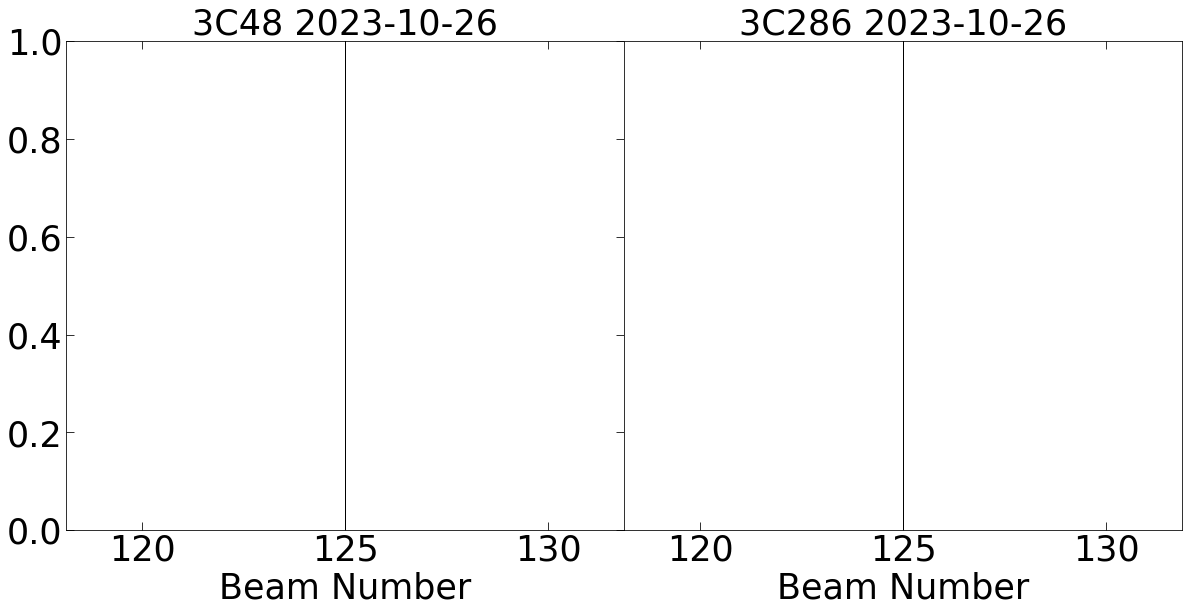

In [60]:
#%%capture --no-stderr
#%%capture --no-stdout
#create pol cal screen
warnings.resetwarnings()
if parsec.state_dict["current_state"] >= parsec.state_map['polcal']:
    with warnings.catch_warnings(record=True):
        warnings.simplefilter('always')
        beam_dict_3C48,beam_dict_3C286 = parsec.polcal_screen(polcaldate_menu,polcaldate_create_menu,polcaldate_bf_menu,polcaldate_findbeams_menu,obsid3C48_menu,obsid3C286_menu,
                                                     polcalbutton,polcopybutton,bfcal_button,findbeams_button,filcalbutton,ParA_display,
                                                     edgefreq_slider,breakfreq_slider,sf_window_weight_cals,sf_order_cals,peakheight_slider,peakwidth_slider,polyfitorder_slider,
                                                     ratio_edgefreq_slider,ratio_breakfreq_slider,ratio_sf_window_weight_cals,ratio_sf_order_cals,ratio_peakheight_slider,ratio_peakwidth_slider,ratio_polyfitorder_slider,
                                                     phase_sf_window_weight_cals,phase_sf_order_cals,phase_peakheight_slider,phase_peakwidth_slider,phase_polyfitorder_slider,savecalsolnbutton,
                                                     sfflag,polyfitflag,ratio_sfflag,ratio_polyfitflag,phase_sfflag,phase_polyfitflag)
    
    

In [48]:
#%%capture --no-stderr
#%%capture --no-stdout
#create pol cal screen
if parsec.state_dict["current_state"] >= parsec.state_map['polcal']:
    parsec.polcal_screen2(polcaldate_menu,polcaldate_create_menu,polcaldate_bf_menu,polcaldate_findbeams_menu,obsid3C48_menu,obsid3C286_menu,
                                                     polcalbutton,polcopybutton,bfcal_button,findbeams_button,filcalbutton,ParA_display,
                                                     edgefreq_slider,breakfreq_slider,sf_window_weight_cals,sf_order_cals,peakheight_slider,peakwidth_slider,polyfitorder_slider,
                                                     ratio_edgefreq_slider,ratio_breakfreq_slider,ratio_sf_window_weight_cals,ratio_sf_order_cals,ratio_peakheight_slider,ratio_peakwidth_slider,ratio_polyfitorder_slider,
                                                     phase_sf_window_weight_cals,phase_sf_order_cals,phase_peakheight_slider,phase_peakwidth_slider,phase_polyfitorder_slider,savecalsolnbutton,
                                                     sfflag,polyfitflag,ratio_sfflag,ratio_polyfitflag,phase_sfflag,phase_polyfitflag,beam_dict_3C48,beam_dict_3C286)
    

In [28]:
#table of new pol cal data
if polcaldate_create_menu.value != "":
    mr.Table(data=parsec.df_polcal, width="200px")


In [29]:

#display voltages and beamformer weight files for current selection
if polcaldate_bf_menu.value != "":
    #display filterbank files if they exist
    if 'polcal_avail_3C48' in parsec.polcal_dict.keys():
        if len(parsec.polcal_dict['polcal_avail_3C48']) == 0:
            mr.Markdown(text=r'###### **3C48 Voltages:** None Found')
        else:
            mr.Markdown(text=r'###### **3C48 Voltages:** ')
            for f in parsec.state_dict['polcal_avail_3C48']:
                mr.Markdown(r'- ######' + f)
    if 'polcal_avail_3C286' in parsec.polcal_dict.keys():
        if len(parsec.polcal_dict['polcal_avail_3C286']) == 0:
            mr.Markdown(text=r'###### **3C286 Voltages:** None Found')
        else:
            mr.Markdown(text=r'###### **3C286 Voltages:** ')
            for f in parsec.polcal_dict['polcal_avail_3C286']:
                mr.Markdown(r'- ######' + f)


In [30]:

#display beamformer weights date if exists
if 'polcal_avail_bf_3C48' in parsec.polcal_dict.keys():
    if len(parsec.polcal_dict['polcal_avail_bf_3C48']) == 0:
        mr.Markdown(text=r'##### **3C48 Beamformer Weights:** None Found')
    else:
        mr.Markdown(text=r'##### **3C48 Beamformer Weights:** ')
        for f in parsec.state_dict['polcal_avail_bf_3C48']:
            mr.Markdown(r'- #####' + f)
if 'polcal_avail_bf_3C286' in parsec.polcal_dict.keys():
    if len(parsec.polcal_dict['polcal_avail_bf_3C286']) == 0:
        mr.Markdown(text=r'##### **3C286 Beamformer Weights:** None Found')
    else:
        mr.Markdown(text=r'##### **3C286 Beamformer Weights:** ')
        for f in parsec.polcal_dict['polcal_avail_bf_3C286']:
            mr.Markdown(r'- #####' + f)


##### **3C48 Beamformer Weights:** None Found

##### **3C286 Beamformer Weights:** None Found

In [31]:

#display beam numbers for each cal pass
mr.Table(data=parsec.df_beams,width="200px") 


In [32]:

#display the filterbank and beamformer weight files for selected observation ID

#3C48 
if obsid3C48_menu.value != '':
    obs_files,obs_ids = polcal.get_calfil_files('3C48',polcaldate_findbeams_menu.value,obsid3C48_menu.value)
    mr.Markdown(text=r'##### **' + obsid3C48_menu.value + ' Filterbanks:**')
    for f in obs_files:
        mr.Markdown(r'- #####' + f)
else:
    mr.Markdown(text = r'##### **' + obsid3C48_menu.value + ' Filterbanks:** None Found')


##### ** Filterbanks:** None Found

In [33]:

if obsid3C48_menu.value in parsec.df_beams.index.tolist():#beam_dict_3C48.keys():
    #print(beam_dict_3C48.keys())
    mr.Markdown(text=r'##### **' + obsid3C48_menu.value + ' Beamformer Weights:**')
    #print(polcal.bfweights_output_path + "*" + polcal.VLANAME_DICT['3C48'] + "*" + parsec.df_beams['beamformer weights'].loc[obsid3C48_menu.value][:19] + "*")
    bf_files = glob.glob(polcal.bfweights_output_path + "*" + polcal.VLANAME_DICT['3C48'] + "*" + parsec.df_beams['beamformer weights'].loc[obsid3C48_menu.value][:19] + "*")
    for f in bf_files:
        mr.Markdown(text = r'- #####' + f)
else:
    mr.Markdown(text = r'##### **' + obsid3C48_menu.value + ' Beamformer Weights:** None Found')


##### ** Beamformer Weights:** None Found

In [34]:

#3C286
if obsid3C286_menu.value != '':
    obs_files,obs_ids = polcal.get_calfil_files('3C286',polcaldate_findbeams_menu.value,obsid3C286_menu.value)
    mr.Markdown(text=r'##### **' + obsid3C286_menu.value + ' Filterbanks:**')
    for f in obs_files:
        mr.Markdown(text = r'- #####' + f)
else:
    mr.Markdown(text = r'##### **' + obsid3C286_menu.value + ' Filterbanks:** None Found')


##### ** Filterbanks:** None Found

In [35]:

if obsid3C286_menu.value in parsec.df_beams.index.tolist():
    mr.Markdown(text=r'##### **' + obsid3C286_menu.value + ' Beamformer Weights:**')
    bf_files = glob.glob(polcal.bfweights_output_path + "*" + polcal.VLANAME_DICT['3C286'] + "*" + parsec.df_beams['beamformer weights'].loc[obsid3C286_menu.value][:19] + "*")
    #print(polcal.bfweights_output_path + "*" + polcal.VLANAME_DICT['3C286'] + "*" + parsec.df_beams['beamformer weights'].loc[obsid3C286_menu.value][:19] +  "*")
    for f in bf_files:
        mr.Markdown(text = r'- #####' + f)
else:
    mr.Markdown(text=r'##### **' + obsid3C286_menu.value + ' Beamformer Weights:** None Found')



##### ** Beamformer Weights:** None Found

In [36]:

#if not (parsec.state_dict["current_state"] >= parsec.state_map['polcal']): raise parsec.StopExecution
ParA_display

In [37]:
# display the output of the logfile
if showlogcal.value:# or refreshlogbutton.clicked:
    flog = open(polcal.logfile,"r")
    logtext = flog.read()
    flog.close()
    mr.Markdown(text=(logtext.replace('\n','\n\n')))


# (3) Filter Weights

In [38]:

#widgets for filter weights dashboard
hidden = toggle_menu.value != '(3) Filter Weights'

ncomps_num = mr.Numeric(value=parsec.wdict['ncomps_num'], 
                     step=1,
                     min=1,max=5,
                     label='Number of Components'
                    ,hidden=hidden)
comprange_slider = mr.Range(value=parsec.wdict['comprange_slider'],  #ms
                        min=0, 
                        max=50, 
                        label="Lower and Upper Limit of Component (ms from window start)", 
                        step=32.7e-3
                ,hidden=hidden)
n_t_slider_filt = mr.Slider( #time downsampling factor
    value=parsec.wdict['n_t_slider_filt'],
    min=1, 
    max=128, 
    step=1, 
    label='$n_t$'
,hidden=hidden)
logn_f_slider_filt = mr.Slider( #freq downsampling factor
    value=parsec.wdict['logn_f_slider_filt'],
    min=0, 
    max=10, 
    step=1, 
    label='${\\rm log_{2}}(n_f)$'
,hidden=hidden)
avger_w_slider = mr.Slider(
    value=parsec.wdict['avger_w_slider'],
    min=1, 
    max=32, 
    step=1, 
    label=r'$n_{tw}$'
,hidden=hidden)
sf_window_weights_slider = mr.Slider(
    value=parsec.wdict['sf_window_weights_slider'],
    min=3, 
    max=33, 
    step=2, 
    label=r'$sf_{ww}$'
,hidden=hidden)
logibox_slider = mr.Slider(
    value=parsec.wdict['logibox_slider'],
    min=0, 
    max=6, 
    step=1, 
    label=r'${\rm log_{2}}({\rm ibox})$'
,hidden=hidden)
logwindow_slider = mr.Slider(
    value=parsec.wdict['logwindow_slider'],
    min=5, 
    max=9, 
    step=1, 
    label=r'base ${\rm log_{2}}({\rm window})$'
,hidden=hidden)

buff_L_slider = mr.Slider(
    value=parsec.wdict['buff_L_slider'],
    min=1, 
    max=128, 
    step=1, 
    label=r'${\rm buff}_{L}$'
,hidden=hidden)
buff_R_slider = mr.Slider(
    value=parsec.wdict['buff_R_slider'],
    min=1, 
    max=128, 
    step=1, 
    label=r'${\rm buff}_{R}$'
,hidden=hidden)

nextcompbutton = mr.Button(label='Next Component',
                         style='primary',hidden=hidden)

donecompbutton = mr.Button(label='Done',
                         style='primary',hidden=hidden)

mercury.Numeric

mercury.Range

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Button

mercury.Button

In [39]:
"""#widget title
hidden = toggle_menu.value != '(3) Filter Weights'

if not hidden:
    mr.Note(text="# Filter Weight Options")"""

'#widget title\nhidden = toggle_menu.value != \'(3) Filter Weights\'\n\nif not hidden:\n    mr.Note(text="# Filter Weight Options")'

In [40]:

mr.Markdown(" (3) Filter Weights")

 (3) Filter Weights

In [41]:



#create pol cal screen
if (parsec.state_dict["current_state"] >= parsec.state_map['filter']):


    parsec.filter_screen(n_t_slider_filt,logn_f_slider_filt,logwindow_slider,logibox_slider,
                     buff_L_slider,buff_R_slider,ncomps_num,comprange_slider,nextcompbutton,donecompbutton,
                    avger_w_slider,sf_window_weights_slider)

In [42]:

mr.Table(data=parsec.df, width="200px")#, text_align="center")


In [43]:

#if not (parsec.state_dict["current_state"] >= parsec.state_map['filter']): raise parsec.StopExecution
mr.NumberBox(data=parsec.state_dict["current_state"], 
                              title=r'Current Screen Index'
                             )